Use conda environment conda_envs/cool_env.yml to run this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bbi
import pybedtools as pbt
import warnings
import cooler
import bioframe
import cooltools
import warnings

In [2]:
import matplotlib as mpl
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

Uploading ChIP-seq data

In [4]:
path_h3k27me3_neun = '/path/to/data/normalised_neun_ppois.bigwig'
path_bmi1_neun = '/path/to/data/normalised_neun_ppois.bigwig'
path_ring1b_neun = '/path/to/data/normalised_neun_ppois.bigwig'

Calculating of average ChIP-seq signal for all the tracks for every 10kb genome bin

In [5]:
# multiBigwigSummary bins --bwfiles /path/to/data/normalised_neun_ppois.bigwig /path/to/data/normalised_neun_ppois.bigwig /path/to/data/normalised_neun_ppois.bigwig --labels H3K27me3 BMI1 Ring1B --binSize 10000 -out scores_per_bin_normalised.npz --outRawCounts scores_per_bin_normalised.tab

In [6]:
scores_per_bin = pd.read_csv('/path/to/data/scores_per_bin_normalised.tab', sep='\t')
scores_per_bin.columns = ['chr', 'start', 'end', 'H3K27me3', 'BMI1', 'Ring1B']
scores_per_bin = scores_per_bin[scores_per_bin['chr'].isin(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11',
                                                           'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'])]
scores_pbt = pbt.BedTool.from_dataframe(scores_per_bin)

Uploading of contact maps and defining regions with NaN values of contact frequency

In [8]:
clr_en = cooler.Cooler('/path/to/data/MTG_LEC_A46_FI_M1C_V1C_Pir_A24.EN.29_42_58_years.17356_cells.1kb.mcool::/resolutions/10000')
clr_in = cooler.Cooler('/path/to/data/MTG_LEC_A46_FI_M1C_V1C_Pir_A24.IN.29_42_58_years.17356_cells.1kb.mcool::/resolutions/10000')
clr_neun = cooler.Cooler('/path/to/data/MTG_LEC_A46_FI_M1C_V1C_Pir_A24.NeuN.29_42_58_years.17356_cells.1kb.mcool::/resolutions/10000')

In [9]:
all_white = []
chroms = [c.values[0] for c in clr_en.chroms()['name']]
clrs = [clr_en, clr_in]

In [10]:
for clr in clrs:
    for chrom in chroms:
        white_for_1chrom = clr.bins().fetch(chrom)[np.isnan(clr.bins().fetch(chrom)['weight'])].reset_index()
        all_white.append(white_for_1chrom)

In [11]:
all_white_bins = pd.concat(all_white)[['chrom', 'start', 'end']].sort_values(by=['chrom', 'start']).drop_duplicates().reset_index(drop=True)
allwhitebins = pbt.BedTool.from_dataframe(all_white_bins)

In [12]:
all_white_bins = allwhitebins.merge().to_dataframe()
all_white_bins['start'] = np.where((all_white_bins['start'] - 50000) > 0, all_white_bins['start'] - 50000, 0)
all_white_bins['end'] = all_white_bins['end'] + 50000
allwhitebins = pbt.BedTool.from_dataframe(all_white_bins)

In [13]:
scores_per_bin = scores_pbt.intersect(allwhitebins, c=True).to_dataframe(names = ['chrom', 'start', 'end', 'H3K27me3', 'BMI1', 'Ring1B', 'whitespace'])
scores_per_bin = scores_per_bin[scores_per_bin['whitespace'] == 0][['chrom', 'start', 'end', 'H3K27me3', 'BMI1', 'Ring1B']].reset_index(drop=True)

Uploading Polycomb-mediated contact coordinates

In [20]:
hand_anch = pd.read_csv("/path/to/data/polycomb_dot_anchors.5kb.16_06_25.csv")
hand_anch[['start', 'end']] = hand_anch[['start', 'end']].astype(int)

In [14]:
blacklist = pd.read_csv('/path/to/data/hg38-blacklist.v2.bed.gz', sep='\t', header=None)
blacklist = blacklist.rename(columns={0: 'chrom', 1: 'start', 2: 'end', 3: 'quality'})
blacklist_pbt = pbt.BedTool.from_dataframe(blacklist)

In [15]:
scores = pbt.BedTool.from_dataframe(scores_per_bin)

In [16]:
scores_per_bin = scores.intersect(blacklist_pbt, c=True).to_dataframe(names = ['chrom', 'start', 'end', 'H3K27me3', 'BMI1', 'Ring1B', 'blacklist'])

In [17]:
scores_per_bin = scores_per_bin[scores_per_bin['blacklist'] == 0][['chrom', 'start', 'end', 'H3K27me3', 'BMI1', 'Ring1B']].reset_index(drop=True)

In [21]:
hand_anch['start'] = hand_anch['start'] - 20000
hand_anch['end'] = hand_anch['end'] + 20000

In [22]:
hand_anch = hand_anch[['chrom', 'start', 'end', 'genes']]

In [23]:
scores = pbt.BedTool.from_dataframe(scores_per_bin)

In [24]:
contacts = pbt.BedTool.from_dataframe(hand_anch)

Adding data for presence of absence of Polycomb-mediated contact for every bin

In [25]:
contact_scores = scores.intersect(contacts, wao=True).to_dataframe(names=['chrom', 'start', 'end', 'H3K27me3', 'BMI1', 'Ring1B', 'chrom2', 'start2', 'end2', 'genes', 'overlap'])

In [26]:
contact_scores['polycomb'] = np.where(contact_scores['overlap'] > 0, 'contact', 'no contact') 

In [27]:
data = contact_scores[['chrom', 'start', 'end', 'H3K27me3', 'BMI1', 'Ring1B', 'polycomb']]

In [31]:
data.loc[:, 'H3K27me3'] = np.where(data['H3K27me3'] == '.', 0, data['H3K27me3'])
data.loc[:, 'BMI1'] = np.where(data['BMI1'] == '.', 0, data['BMI1'])
data.loc[:, 'Ring1B'] = np.where(data['Ring1B'] == '.', 0, data['Ring1B'])

In [32]:
data.loc[:, 'H3K27me3'] = pd.to_numeric(data['H3K27me3'])
data.loc[:, 'BMI1'] = pd.to_numeric(data['BMI1'])
data.loc[:, 'Ring1B'] = pd.to_numeric(data['Ring1B'])

In [33]:
data.groupby('polycomb').size()

polycomb
contact         2097
no contact    234944
dtype: int64

Sorting genome bins by ChIP-seq signal levels in ascending order

In [34]:
h3k27me3_sorted = data.sort_values(by='H3K27me3').reset_index(drop=True)
bmi1_sorted = data.sort_values(by='BMI1').reset_index(drop=True)
ring1b_sorted = data.sort_values(by='Ring1B').reset_index(drop=True)

Defining of inflection points, beyond which the signal values increases sharply, and splitting bins into ones with 'low' and 'high' ChIP-seq signal

In [35]:
h3k27me3_sorted['signal'] = np.where(h3k27me3_sorted['H3K27me3'] > 2, 'high', 'low')
bmi1_sorted['signal'] = np.where(bmi1_sorted['BMI1'] > 2, 'high', 'low')
ring1b_sorted['signal'] = np.where(ring1b_sorted['Ring1B'] > 0.75, 'high', 'low')

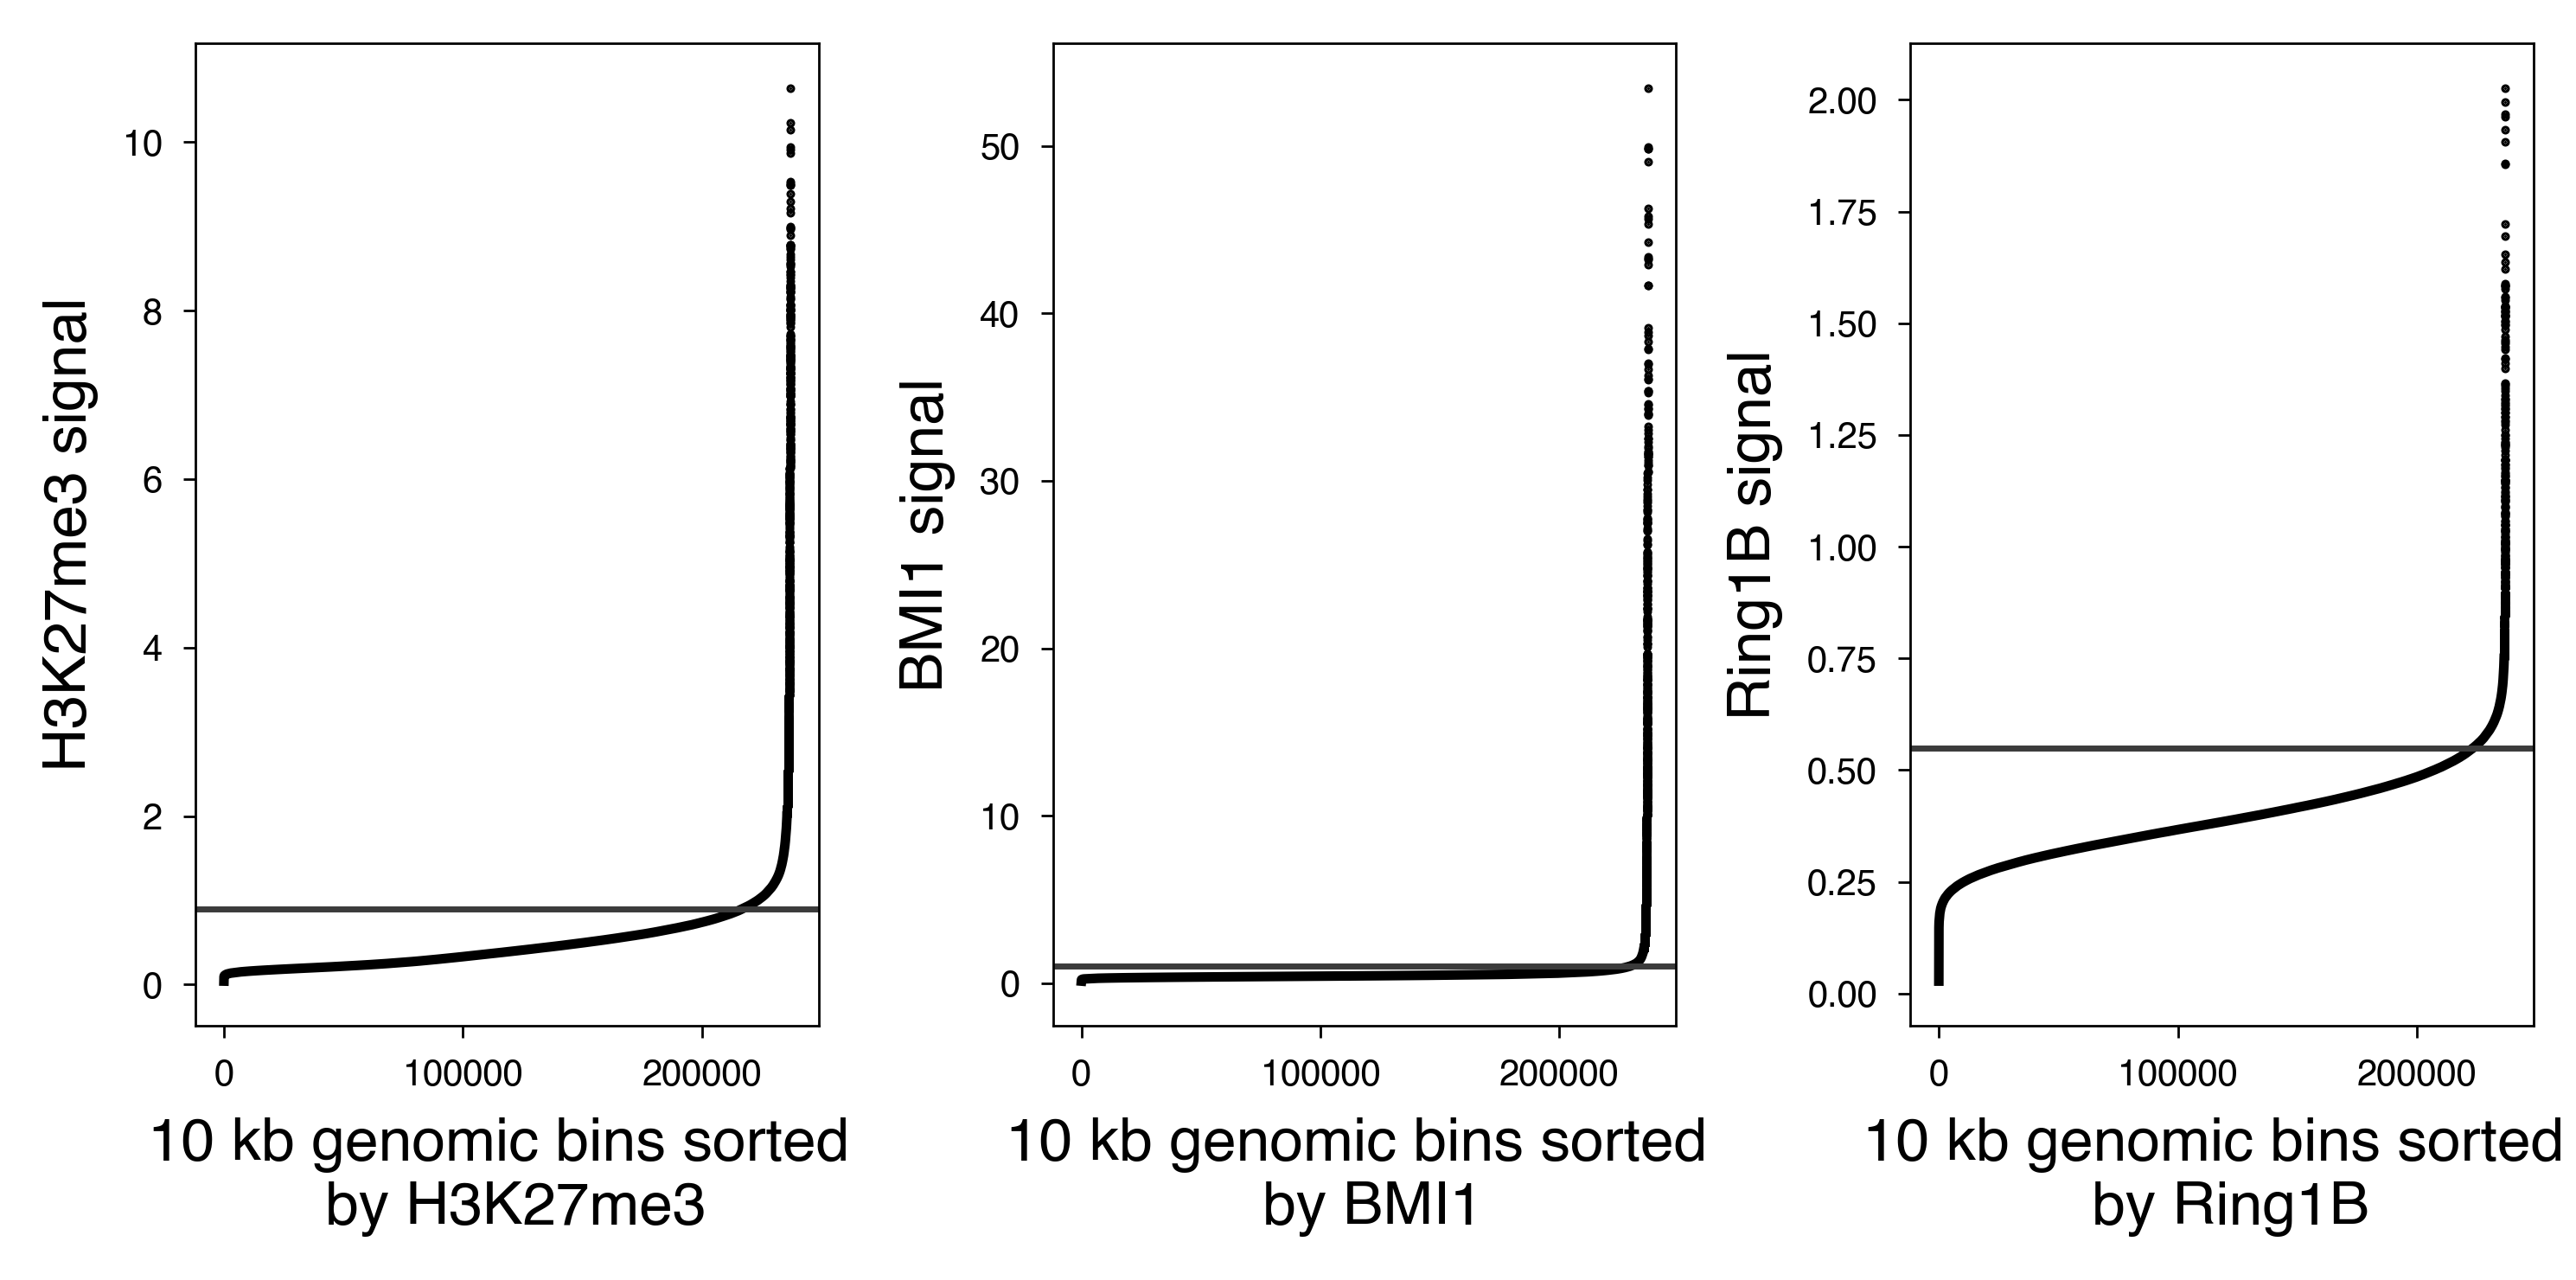

In [36]:
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(6, 3), dpi=500)

axs[0].scatter(h3k27me3_sorted[h3k27me3_sorted['signal'] == 'high'].index, h3k27me3_sorted[h3k27me3_sorted['signal'] == 'high']['H3K27me3'], color='black', s=0.2, rasterized=True)
axs[0].plot(h3k27me3_sorted[h3k27me3_sorted['signal'] == 'low'].index, h3k27me3_sorted[h3k27me3_sorted['signal'] == 'low']['H3K27me3'], color='black', linewidth=1.6)
axs[0].set_ylabel('H3K27me3 signal', fontsize=10)
axs[0].set_xlabel("10 kb genomic bins sorted \n by H3K27me3", fontsize=10)
axs[0].axhline(y=0.9, color='#3b3b3b', linewidth=1)  

axs[1].scatter(bmi1_sorted[bmi1_sorted['signal'] == 'high'].index, bmi1_sorted[bmi1_sorted['signal'] == 'high']['BMI1'], color='black', s=0.2, rasterized=True)
axs[1].plot(bmi1_sorted[bmi1_sorted['signal'] == 'low'].index, bmi1_sorted[bmi1_sorted['signal'] == 'low']['BMI1'], color='black', linewidth=1.6)
axs[1].set_ylabel('BMI1 signal', fontsize=10)
axs[1].set_xlabel("10 kb genomic bins sorted \n by BMI1", fontsize=10)
axs[1].axhline(y=1, color='#3b3b3b', linewidth=1) 

axs[2].scatter(ring1b_sorted[ring1b_sorted['signal'] == 'high'].index, ring1b_sorted[ring1b_sorted['signal'] == 'high']['Ring1B'], color='black', s=0.2, rasterized=True)
axs[2].plot(ring1b_sorted[ring1b_sorted['signal'] == 'low'].index, ring1b_sorted[ring1b_sorted['signal'] == 'low']['Ring1B'], color='black', linewidth=1.6)
axs[2].set_ylabel('Ring1B signal', fontsize=10)
axs[2].set_xlabel("10 kb genomic bins sorted \n by Ring1B", fontsize=10)
axs[2].axhline(y=0.55, color='#3b3b3b', linewidth=1) 

# plt.savefig('signal_levels_final_rasterized.pdf', format='pdf', bbox_inches='tight')
plt.show()

Splitting 'high signal' bins into 20 equal deciles and defining the part of Polycomb-mediated contact-forming bins for every decile

In [37]:
bmi1_high = bmi1_sorted[bmi1_sorted['signal'] == 'high'].sort_values(by='BMI1').reset_index(drop=True)

In [38]:
bmi1_high['decile'] = pd.qcut(bmi1_high.index, 20, labels=False)

In [39]:
bmi1_high['decile'] = bmi1_high['decile'] + 1

In [40]:
bmi1_low = bmi1_sorted[bmi1_sorted['signal'] == 'low'].sort_values(by='BMI1').reset_index(drop=True)
bmi1_low['decile'] = 0
bmi1_high = pd.concat([bmi1_low, bmi1_high]).reset_index(drop=True)

In [41]:
bmi1_high['polycomb'] = np.where(bmi1_high['polycomb'] == 'contact', 1, 0)

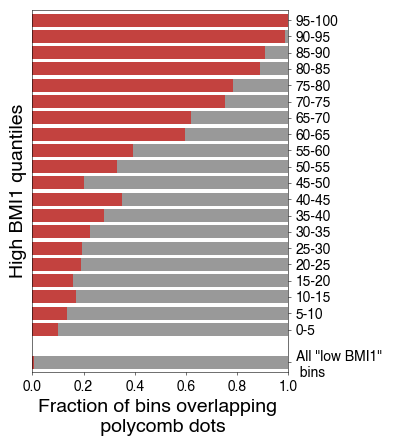

In [42]:
plt.figure(figsize=(4, 4.5))

decile_counts = bmi1_high.groupby('decile')['polycomb'].agg(
    contact_count='sum',
    no_contact_count=lambda x: len(x) - x.sum()
).reset_index()

decile_counts['total'] = decile_counts['contact_count'] + decile_counts['no_contact_count']
decile_counts['no_contact_ratio'] = decile_counts['no_contact_count'] / decile_counts['total']
decile_counts['contact_ratio'] = decile_counts['contact_count'] / decile_counts['total']

y_positions = np.array([0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5])
plt.barh(y_positions, decile_counts['contact_ratio'], height=0.4, color='#c3423f')
plt.barh(y_positions, decile_counts['no_contact_ratio'], left=decile_counts['contact_ratio'], height=0.4, color='#999999')

ax = plt.gca()
ax.margins(y=0.01)
ax.yaxis.set_ticks_position('right')
plt.yticks(ticks=np.array([0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5]), 
           labels=['All "low BMI1" \n bins', '0-5', '5-10', '10-15', '15-20', 
                   '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', 
                  '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', 
                  '90-95', '95-100'], fontsize=10)
ax.yaxis.set_label_position('left')
ax.set_ylabel('High BMI1 quantiles', fontsize=14, rotation=90, va='center', labelpad=10)

plt.xticks(fontsize=10)
plt.xlim(0, 1)
plt.xlabel('Fraction of bins overlapping \n polycomb dots', fontsize=14) 
plt.tight_layout()

# plt.savefig('bmi1_deciles_new.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [43]:
h3k27me3_high = h3k27me3_sorted[h3k27me3_sorted['signal'] == 'high'].sort_values(by='H3K27me3').reset_index(drop=True)

In [44]:
h3k27me3_high['decile'] = pd.qcut(h3k27me3_high.index, 20, labels=False)
h3k27me3_high['decile'] = h3k27me3_high['decile'] + 1

In [45]:
h3k27me3_low = h3k27me3_sorted[h3k27me3_sorted['signal'] == 'low'].sort_values(by='H3K27me3').reset_index(drop=True)
h3k27me3_low['decile'] = 0
h3k27me3_high = pd.concat([h3k27me3_low, h3k27me3_high]).reset_index(drop=True)

In [46]:
h3k27me3_high['polycomb'] = np.where(h3k27me3_high['polycomb'] == 'contact', 1, 0)

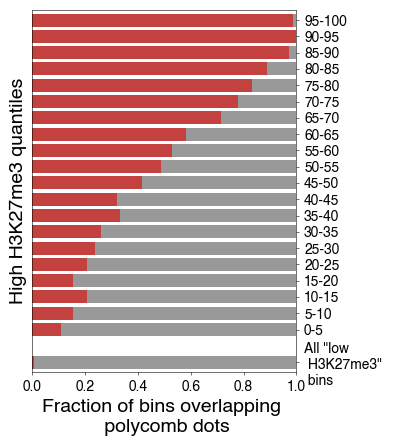

In [47]:
plt.figure(figsize=(4, 4.5))

decile_counts = h3k27me3_high.groupby('decile')['polycomb'].agg(
    contact_count='sum',
    no_contact_count=lambda x: len(x) - x.sum()
).reset_index()

decile_counts['total'] = decile_counts['contact_count'] + decile_counts['no_contact_count']
decile_counts['no_contact_ratio'] = decile_counts['no_contact_count'] / decile_counts['total']
decile_counts['contact_ratio'] = decile_counts['contact_count'] / decile_counts['total']

y_positions = np.array([0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5])
plt.barh(y_positions, decile_counts['contact_ratio'], height=0.4, color='#c3423f')
plt.barh(y_positions, decile_counts['no_contact_ratio'], left=decile_counts['contact_ratio'], height=0.4, color='#999999')

ax = plt.gca()
ax.margins(y=0.01)
ax.yaxis.set_ticks_position('right')
plt.yticks(ticks=np.array([0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5]), 
           labels=['All "low \n H3K27me3" \n bins', '0-5', '5-10', '10-15', '15-20', 
                   '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', 
                  '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', 
                  '90-95', '95-100'], fontsize=10)
ax.yaxis.set_label_position('left')
ax.set_ylabel('High H3K27me3 quantiles', fontsize=14, rotation=90, va='center', labelpad=10)

plt.xticks(fontsize=10)
plt.xlim(0, 1)
plt.xlabel('Fraction of bins overlapping \n polycomb dots', fontsize=14) 
plt.tight_layout()

# plt.savefig('h3k27me3_deciles_new.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [48]:
ring1b_high = ring1b_sorted[ring1b_sorted['signal'] == 'high'].sort_values(by='Ring1B').reset_index(drop=True)

In [49]:
ring1b_high['decile'] = pd.qcut(ring1b_high.index, 20, labels=False)
ring1b_high['decile'] = ring1b_high['decile'] + 1

In [50]:
ring1b_low = ring1b_sorted[ring1b_sorted['signal'] == 'low'].sort_values(by='Ring1B').reset_index(drop=True)
ring1b_low['decile'] = 0
ring1b_high = pd.concat([ring1b_low, ring1b_high]).reset_index(drop=True)

In [51]:
ring1b_high['polycomb'] = np.where(ring1b_high['polycomb'] == 'contact', 1, 0)

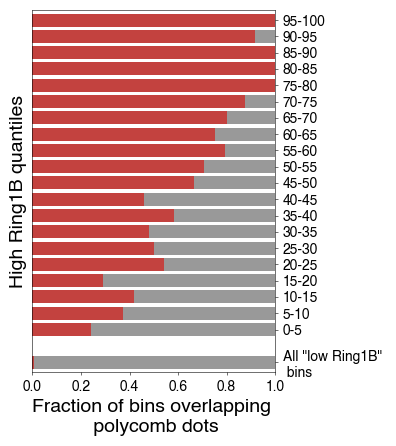

In [52]:
plt.figure(figsize=(4, 4.5))

decile_counts = ring1b_high.groupby('decile')['polycomb'].agg(
    contact_count='sum',
    no_contact_count=lambda x: len(x) - x.sum()
).reset_index()

decile_counts['total'] = decile_counts['contact_count'] + decile_counts['no_contact_count']
decile_counts['no_contact_ratio'] = decile_counts['no_contact_count'] / decile_counts['total']
decile_counts['contact_ratio'] = decile_counts['contact_count'] / decile_counts['total']

y_positions = np.array([0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5])
plt.barh(y_positions, decile_counts['contact_ratio'], height=0.4, color='#c3423f')
plt.barh(y_positions, decile_counts['no_contact_ratio'], left=decile_counts['contact_ratio'], height=0.4, color='#999999')

ax = plt.gca()
ax.margins(y=0.01)
ax.yaxis.set_ticks_position('right')
plt.yticks(ticks=np.array([0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5]), 
           labels=['All "low Ring1B" \n bins', '0-5', '5-10', '10-15', '15-20', 
                   '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', 
                  '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', 
                  '90-95', '95-100'], fontsize=10)
ax.yaxis.set_label_position('left')
ax.set_ylabel('High Ring1B quantiles', fontsize=14, rotation=90, va='center', labelpad=10)

plt.xticks(fontsize=10)
plt.xlim(0, 1)
plt.xlabel('Fraction of bins overlapping \n polycomb dots', fontsize=14) 
plt.tight_layout()

# plt.savefig('ring1b_deciles_new.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [53]:
bmi1_high = bmi1_high[bmi1_high['decile'] > 0].sort_values(by=['decile', 'chrom', 'start']).reset_index(drop=True)

In [54]:
h3k27me3_high = h3k27me3_high[h3k27me3_high['decile'] > 0].sort_values(by=['decile', 'chrom', 'start']).reset_index(drop=True)

In [55]:
ring1b_high = ring1b_high[ring1b_high['decile'] > 0].sort_values(by=['decile', 'chrom', 'start']).reset_index(drop=True)

In [56]:
bmi1_high_loops = pd.DataFrame(columns=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'decile'])

In [57]:
h3k27me3_high_loops = pd.DataFrame(columns=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'decile'])

In [58]:
ring1b_high_loops = pd.DataFrame(columns=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'decile'])

Defining loop coordinates for every pair of 'high signal' bins located further than 3Mb

In [59]:
for i, irow in bmi1_high.iterrows():
    for j, jrow in bmi1_high[(bmi1_high['chrom'] == irow['chrom']) & (bmi1_high['decile'] == irow['decile'])].iterrows():
        if jrow['start']-irow['start'] > 3000000:
            n = len(bmi1_high_loops)
            bmi1_high_loops.loc[n, 'chrom1'] = irow['chrom']
            bmi1_high_loops.loc[n, 'start1'] = irow['start']
            bmi1_high_loops.loc[n, 'end1'] = irow['end']
            bmi1_high_loops.loc[n, 'chrom2'] = jrow['chrom']
            bmi1_high_loops.loc[n, 'start2'] = jrow['start']
            bmi1_high_loops.loc[n, 'end2'] = jrow['end']
            bmi1_high_loops.loc[n, 'decile'] = jrow['decile']

In [60]:
for i, irow in h3k27me3_high.iterrows():
    for j, jrow in h3k27me3_high[(h3k27me3_high['chrom'] == irow['chrom']) & (h3k27me3_high['decile'] == irow['decile'])].iterrows():
        if jrow['start']-irow['start'] > 3000000:
            n = len(h3k27me3_high_loops)
            h3k27me3_high_loops.loc[n, 'chrom1'] = irow['chrom']
            h3k27me3_high_loops.loc[n, 'start1'] = irow['start']
            h3k27me3_high_loops.loc[n, 'end1'] = irow['end']
            h3k27me3_high_loops.loc[n, 'chrom2'] = jrow['chrom']
            h3k27me3_high_loops.loc[n, 'start2'] = jrow['start']
            h3k27me3_high_loops.loc[n, 'end2'] = jrow['end']
            h3k27me3_high_loops.loc[n, 'decile'] = jrow['decile']

In [61]:
for i, irow in ring1b_high.iterrows():
    for j, jrow in ring1b_high[(ring1b_high['chrom'] == irow['chrom']) & (ring1b_high['decile'] == irow['decile'])].iterrows():
        if jrow['start']-irow['start'] > 3000000:
            n = len(ring1b_high_loops)
            ring1b_high_loops.loc[n, 'chrom1'] = irow['chrom']
            ring1b_high_loops.loc[n, 'start1'] = irow['start']
            ring1b_high_loops.loc[n, 'end1'] = irow['end']
            ring1b_high_loops.loc[n, 'chrom2'] = jrow['chrom']
            ring1b_high_loops.loc[n, 'start2'] = jrow['start']
            ring1b_high_loops.loc[n, 'end2'] = jrow['end']
            ring1b_high_loops.loc[n, 'decile'] = jrow['decile']

In [62]:
bmi1_high_loops['start1'] = bmi1_high_loops['start1'].astype('int')
bmi1_high_loops['end1'] = bmi1_high_loops['end1'].astype('int')
bmi1_high_loops['start2'] = bmi1_high_loops['start2'].astype('int')
bmi1_high_loops['end2'] = bmi1_high_loops['end2'].astype('int')
bmi1_high_loops = bmi1_high_loops.sort_values(by = ['chrom1', 'start1'])
bmi1_high_loops['distance'] = bmi1_high_loops['start2']-bmi1_high_loops['start1']
bmi1_high_loops['strand1'] = '+'
bmi1_high_loops['strand2'] = '-'

In [63]:
h3k27me3_high_loops['start1'] = h3k27me3_high_loops['start1'].astype('int')
h3k27me3_high_loops['end1'] = h3k27me3_high_loops['end1'].astype('int')
h3k27me3_high_loops['start2'] = h3k27me3_high_loops['start2'].astype('int')
h3k27me3_high_loops['end2'] = h3k27me3_high_loops['end2'].astype('int')
h3k27me3_high_loops = h3k27me3_high_loops.sort_values(by = ['chrom1', 'start1'])
h3k27me3_high_loops['distance'] = h3k27me3_high_loops['start2']-h3k27me3_high_loops['start1']
h3k27me3_high_loops['strand1'] = '+'
h3k27me3_high_loops['strand2'] = '-'

In [64]:
ring1b_high_loops['start1'] = ring1b_high_loops['start1'].astype('int')
ring1b_high_loops['end1'] = ring1b_high_loops['end1'].astype('int')
ring1b_high_loops['start2'] = ring1b_high_loops['start2'].astype('int')
ring1b_high_loops['end2'] = ring1b_high_loops['end2'].astype('int')
ring1b_high_loops = ring1b_high_loops.sort_values(by = ['chrom1', 'start1'])
ring1b_high_loops['distance'] = ring1b_high_loops['start2']-ring1b_high_loops['start1']
ring1b_high_loops['strand1'] = '+'
ring1b_high_loops['strand2'] = '-'

In [65]:
bmi1_high_loops1 = bmi1_high_loops[bmi1_high_loops['decile'] == 1].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops2 = bmi1_high_loops[bmi1_high_loops['decile'] == 2].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops3 = bmi1_high_loops[bmi1_high_loops['decile'] == 3].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops4 = bmi1_high_loops[bmi1_high_loops['decile'] == 4].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops5 = bmi1_high_loops[bmi1_high_loops['decile'] == 5].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops6 = bmi1_high_loops[bmi1_high_loops['decile'] == 6].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops7 = bmi1_high_loops[bmi1_high_loops['decile'] == 7].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops8 = bmi1_high_loops[bmi1_high_loops['decile'] == 8].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops9 = bmi1_high_loops[bmi1_high_loops['decile'] == 9].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops10 = bmi1_high_loops[bmi1_high_loops['decile'] == 10].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops11 = bmi1_high_loops[bmi1_high_loops['decile'] == 11].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops12 = bmi1_high_loops[bmi1_high_loops['decile'] == 12].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops13 = bmi1_high_loops[bmi1_high_loops['decile'] == 13].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops14 = bmi1_high_loops[bmi1_high_loops['decile'] == 14].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops15 = bmi1_high_loops[bmi1_high_loops['decile'] == 15].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops16 = bmi1_high_loops[bmi1_high_loops['decile'] == 16].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops17 = bmi1_high_loops[bmi1_high_loops['decile'] == 17].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops18 = bmi1_high_loops[bmi1_high_loops['decile'] == 18].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops19 = bmi1_high_loops[bmi1_high_loops['decile'] == 19].reset_index(drop=True).drop(columns=['decile'])
bmi1_high_loops20 = bmi1_high_loops[bmi1_high_loops['decile'] == 20].reset_index(drop=True).drop(columns=['decile'])

In [66]:
h3k27me3_high_loops1 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 1].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops2 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 2].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops3 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 3].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops4 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 4].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops5 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 5].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops6 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 6].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops7 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 7].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops8 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 8].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops9 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 9].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops10 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 10].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops11 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 11].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops12 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 12].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops13 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 13].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops14 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 14].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops15 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 15].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops16 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 16].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops17 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 17].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops18 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 18].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops19 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 19].reset_index(drop=True).drop(columns=['decile'])
h3k27me3_high_loops20 = h3k27me3_high_loops[h3k27me3_high_loops['decile'] == 20].reset_index(drop=True).drop(columns=['decile'])

In [67]:
ring1b_high_loops1 = ring1b_high_loops[ring1b_high_loops['decile'] == 1].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops2 = ring1b_high_loops[ring1b_high_loops['decile'] == 2].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops3 = ring1b_high_loops[ring1b_high_loops['decile'] == 3].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops4 = ring1b_high_loops[ring1b_high_loops['decile'] == 4].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops5 = ring1b_high_loops[ring1b_high_loops['decile'] == 5].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops6 = ring1b_high_loops[ring1b_high_loops['decile'] == 6].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops7 = ring1b_high_loops[ring1b_high_loops['decile'] == 7].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops8 = ring1b_high_loops[ring1b_high_loops['decile'] == 8].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops9 = ring1b_high_loops[ring1b_high_loops['decile'] == 9].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops10 = ring1b_high_loops[ring1b_high_loops['decile'] == 10].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops11 = ring1b_high_loops[ring1b_high_loops['decile'] == 11].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops12 = ring1b_high_loops[ring1b_high_loops['decile'] == 12].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops13 = ring1b_high_loops[ring1b_high_loops['decile'] == 13].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops14 = ring1b_high_loops[ring1b_high_loops['decile'] == 14].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops15 = ring1b_high_loops[ring1b_high_loops['decile'] == 15].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops16 = ring1b_high_loops[ring1b_high_loops['decile'] == 16].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops17 = ring1b_high_loops[ring1b_high_loops['decile'] == 17].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops18 = ring1b_high_loops[ring1b_high_loops['decile'] == 18].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops19 = ring1b_high_loops[ring1b_high_loops['decile'] == 19].reset_index(drop=True).drop(columns=['decile'])
ring1b_high_loops20 = ring1b_high_loops[ring1b_high_loops['decile'] == 20].reset_index(drop=True).drop(columns=['decile'])

Calculating of average profile for every loop using contact maps for EN and IN and merged map for neurons

In [68]:
bmi1_decile_list = [ bmi1_high_loops16, bmi1_high_loops17, bmi1_high_loops18, bmi1_high_loops19, bmi1_high_loops20]

In [69]:
h3k27me3_decile_list = [h3k27me3_high_loops16, h3k27me3_high_loops17, h3k27me3_high_loops18, h3k27me3_high_loops19, h3k27me3_high_loops20]

In [70]:
ring1b_decile_list = [ring1b_high_loops16, ring1b_high_loops17, ring1b_high_loops18, ring1b_high_loops19, ring1b_high_loops20]

In [71]:
resolution = clr_en.binsize
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
hg38_arms = hg38_arms.set_index("chrom").loc[clr_en.chromnames].reset_index()

In [72]:
exp_neun = cooltools.expected_cis(clr_neun, view_df=hg38_arms, nproc=2, chunksize=1_000_000)
exp_en = cooltools.expected_cis(clr_en, view_df=hg38_arms, nproc=2, chunksize=1_000_000)
exp_in = cooltools.expected_cis(clr_in, view_df=hg38_arms, nproc=2, chunksize=1_000_000)

/home/kuzn_rina/.conda/envs/coolclone/lib/python3.10/site-packages/cooltools/api/expected.py:327: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


In [73]:
warnings.filterwarnings('ignore')
for i in range(len(bmi1_decile_list)):
    loops = bmi1_decile_list[i]
    loops['start1'] = loops['start1'].astype(int)
    loops['start2'] = loops['start2'].astype(int)
    loops['end1'] = loops['end1'].astype(int)
    loops['end2'] = loops['end2'].astype(int)
    loops['mid1'] = (loops['start1']+loops['end1'])/2
    loops['mid2'] = (loops['start2']+loops['end2'])/2

    stack = cooltools.pileup(clr_neun, loops, view_df=hg38_arms, expected_df=exp_neun, flank=150_000)
    np.save(f'/path/to/data/stack_bmi1_neun_{str(i)}_loops_10kb_new.npy', stack)

warnings.filterwarnings('ignore')
for i in range(len(h3k27me3_decile_list)):
    loops = h3k27me3_decile_list[i]
    loops['start1'] = loops['start1'].astype(int)
    loops['start2'] = loops['start2'].astype(int)
    loops['end1'] = loops['end1'].astype(int)
    loops['end2'] = loops['end2'].astype(int)
    loops['mid1'] = (loops['start1']+loops['end1'])/2
    loops['mid2'] = (loops['start2']+loops['end2'])/2

    stack = cooltools.pileup(clr_neun, loops, view_df=hg38_arms, expected_df=exp_neun, flank=150_000)
    np.save(f'/path/to/data/stack_h3k27me3_neun_{str(i)}_loops_10kb_new.npy', stack)

warnings.filterwarnings('ignore')
for i in range(len(ring1b_decile_list)):
    loops = ring1b_decile_list[i]
    loops['start1'] = loops['start1'].astype(int)
    loops['start2'] = loops['start2'].astype(int)
    loops['end1'] = loops['end1'].astype(int)
    loops['end2'] = loops['end2'].astype(int)
    loops['mid1'] = (loops['start1']+loops['end1'])/2
    loops['mid2'] = (loops['start2']+loops['end2'])/2

    stack = cooltools.pileup(clr_neun, loops, view_df=hg38_arms, expected_df=exp_neun, flank=150_000)
    np.save(f'/path/to/data/stack_ring1b_neun_{str(i)}_loops_10kb_new.npy', stack)

In [78]:
warnings.filterwarnings('ignore')
for i in range(len(bmi1_decile_list)):
    loops = bmi1_decile_list[i]
    loops['start1'] = loops['start1'].astype(int)
    loops['start2'] = loops['start2'].astype(int)
    loops['end1'] = loops['end1'].astype(int)
    loops['end2'] = loops['end2'].astype(int)
    loops['mid1'] = (loops['start1']+loops['end1'])/2
    loops['mid2'] = (loops['start2']+loops['end2'])/2

    stack = cooltools.pileup(clr_en, loops, view_df=hg38_arms, expected_df=exp_en, flank=150_000)
    np.save(f'/path/to/data/stack_bmi1_en_{str(i)}_loops_10kb_new.npy', stack)

warnings.filterwarnings('ignore')
for i in range(len(h3k27me3_decile_list)):
    loops = h3k27me3_decile_list[i]
    loops['start1'] = loops['start1'].astype(int)
    loops['start2'] = loops['start2'].astype(int)
    loops['end1'] = loops['end1'].astype(int)
    loops['end2'] = loops['end2'].astype(int)
    loops['mid1'] = (loops['start1']+loops['end1'])/2
    loops['mid2'] = (loops['start2']+loops['end2'])/2

    stack = cooltools.pileup(clr_en, loops, view_df=hg38_arms, expected_df=exp_en, flank=150_000)
    np.save(f'/path/to/data/stack_h3k27me3_en_{str(i)}_loops_10kb_new.npy', stack)

warnings.filterwarnings('ignore')
for i in range(len(ring1b_decile_list)):
    loops = ring1b_decile_list[i]
    loops['start1'] = loops['start1'].astype(int)
    loops['start2'] = loops['start2'].astype(int)
    loops['end1'] = loops['end1'].astype(int)
    loops['end2'] = loops['end2'].astype(int)
    loops['mid1'] = (loops['start1']+loops['end1'])/2
    loops['mid2'] = (loops['start2']+loops['end2'])/2

    stack = cooltools.pileup(clr_en, loops, view_df=hg38_arms, expected_df=exp_en, flank=150_000)
    np.save(f'/path/to/data/stack_ring1b_en_{str(i)}_loops_10kb_new.npy', stack)

In [79]:
warnings.filterwarnings('ignore')
for i in range(len(bmi1_decile_list)):
    loops = bmi1_decile_list[i]
    loops['start1'] = loops['start1'].astype(int)
    loops['start2'] = loops['start2'].astype(int)
    loops['end1'] = loops['end1'].astype(int)
    loops['end2'] = loops['end2'].astype(int)
    loops['mid1'] = (loops['start1']+loops['end1'])/2
    loops['mid2'] = (loops['start2']+loops['end2'])/2

    stack = cooltools.pileup(clr_in, loops, view_df=hg38_arms, expected_df=exp_in, flank=150_000)
    np.save(f'/path/to/data/stack_bmi1_in_{str(i)}_loops_10kb_new.npy', stack)

warnings.filterwarnings('ignore')
for i in range(len(h3k27me3_decile_list)):
    loops = h3k27me3_decile_list[i]
    loops['start1'] = loops['start1'].astype(int)
    loops['start2'] = loops['start2'].astype(int)
    loops['end1'] = loops['end1'].astype(int)
    loops['end2'] = loops['end2'].astype(int)
    loops['mid1'] = (loops['start1']+loops['end1'])/2
    loops['mid2'] = (loops['start2']+loops['end2'])/2

    stack = cooltools.pileup(clr_in, loops, view_df=hg38_arms, expected_df=exp_in, flank=150_000)
    np.save(f'/path/to/data/stack_h3k27me3_in_{str(i)}_loops_10kb_new.npy', stack)

warnings.filterwarnings('ignore')
for i in range(len(ring1b_decile_list)):
    loops = ring1b_decile_list[i]
    loops['start1'] = loops['start1'].astype(int)
    loops['start2'] = loops['start2'].astype(int)
    loops['end1'] = loops['end1'].astype(int)
    loops['end2'] = loops['end2'].astype(int)
    loops['mid1'] = (loops['start1']+loops['end1'])/2
    loops['mid2'] = (loops['start2']+loops['end2'])/2

    stack = cooltools.pileup(clr_in, loops, view_df=hg38_arms, expected_df=exp_in, flank=150_000)
    np.save(f'/path/to/data/stack_ring1b_in_{str(i)}_loops_10kb_new.npy', stack)

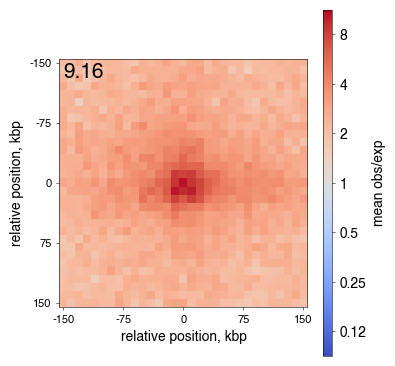

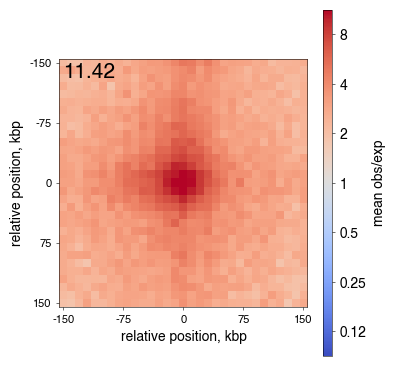

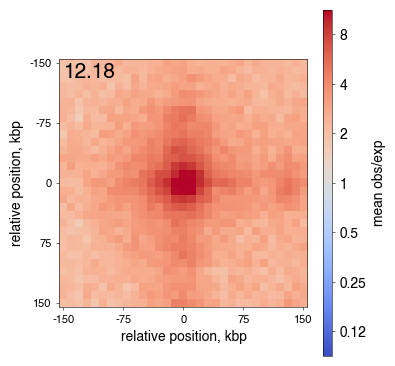

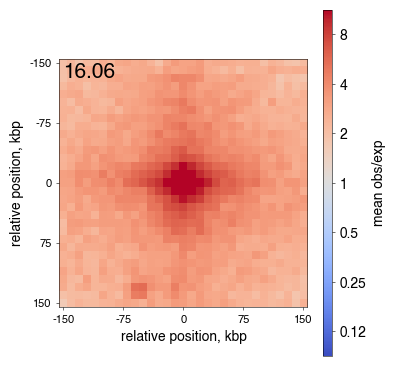

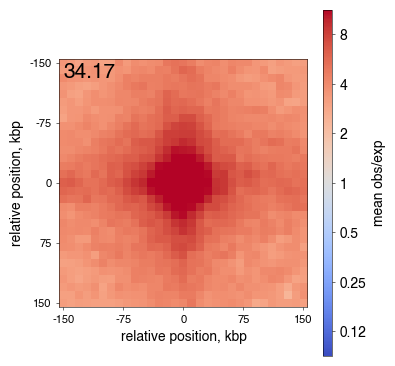

In [80]:
warnings.filterwarnings('ignore')
for map in ['en']:  
    for chip in ['bmi1']:  
        for i in range(5): 
            stack = np.load(f'/path/to/data/stack_{chip}_{map}_{str(i)}_loops_10kb_new.npy')
            mtx = np.nanmean(stack, axis=0)
            mtx_center = []
            for j in range(stack.shape[0]):
                center_x1 = stack.shape[1]//2-1
                center_x2 = stack.shape[1]//2+2
                center_y1 = stack.shape[2]//2-1
                center_y2 = stack.shape[2]//2+2
                center = stack[j, center_x1:center_x2, center_y1:center_y2]
                central_score = np.nanmean(center)
                mtx_center.append(central_score)

            plt.figure(figsize=(4, 4.5))
            log_mtx = np.log2(mtx) 
            plt.imshow(
                log_mtx,
                vmax=3.5,
                vmin=-3.5,
                cmap='coolwarm'
            )
    
            cbar = plt.colorbar(aspect=40)
            cbar.set_label('mean obs/exp', fontsize=10)
            cbar.ax.yaxis.set_tick_params(labelsize=10)
    
            ticks = [-3, -2, -1, 0, 1, 2, 3]  
            original_values = [2**tick for tick in ticks]  
            cbar.set_ticks(ticks)
            cbar.set_ticklabels([f"{value:.2g}" for value in original_values]) 
    
            resolution = 10000
            flank = 150000

            ticks_pixels = np.linspace(0, flank * 2 // resolution, 5)
            ticks_kbp = ((ticks_pixels - ticks_pixels[-1] / 2) * resolution // 1000).astype(int)
            plt.xticks(ticks_pixels, ticks_kbp, fontsize=8)
            plt.yticks(ticks_pixels, ticks_kbp, fontsize=8)

            plt.xlabel('relative position, kbp', fontsize=10)
            plt.ylabel('relative position, kbp', fontsize=10)
            
            plt.text(0, 0, f'{np.nanmean(mtx_center):.2f}', color='black', 
                     fontsize=15, ha='left', va='top')

            # plt.savefig(f'/path/to/data/loops_{chip}_{map}_{str(i+1)}_norm.pdf', format='pdf', bbox_inches='tight')
            plt.show()
            plt.close()